<a href="https://colab.research.google.com/github/koushik-varma-m/Neural-Networks/blob/main/micrograd_Basic_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
  return 3*x**2 - 4*x + 5

In [5]:
f(3)

20

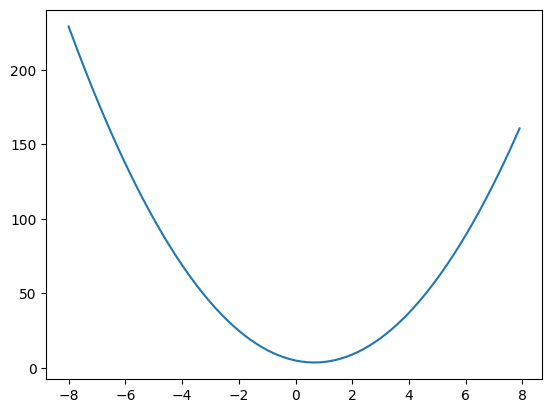

In [6]:
xs = np.arange(-8,8,0.1)
ys = f(xs)
plt.plot(xs,ys)

In [7]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

The Above calculations and graph told that how the differentitaion of a function can be done.

In [8]:
#Lets create some complex equations
a=10
b=5
c=4
d=a*(b+c)
d

90

In [9]:
h=0.00001

a=4
b=2
c=6

d1=c*(a+b)
c+=h
d2=c*(a+b)
#here we are trying to know the slope of the function or the differentiation of the function with respect to c. Similarly we can determine for all other varibales.
print("d1",d1)
print("d2",d2)
print("slope",(d2-d1)/h)

d1 36
d2 36.00006
slope 5.999999999772853


From here onwards lets build a basic neural network and learn how the forward pass and backpropogation done in a neural network.

In order to create a neural network lets create a class called value which is used as part of the neuron to do some calcultions and perform certain tasks.

In [12]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward()

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    vis = set()
    def build(v):
      if v not in vis:
        vis.add(v)
        for child in v._prev:
          build(child)
        topo.append(v)
    build(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [11]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

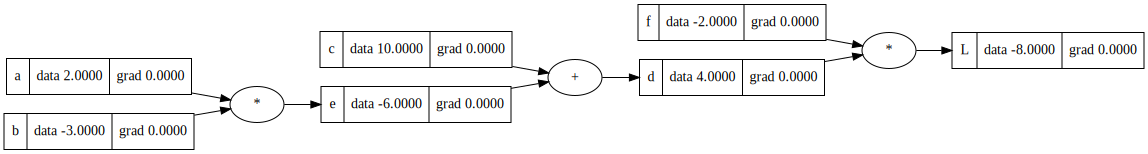

In [13]:
draw_dot(L)